In [1]:
#git location: https://github.com/Salister112/HSMA4MAS

#Load standard modules numpy and pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

#library 
import textwrap as twp

#Import Machine Learning modules
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

#Import spreadsheet manipulation modules
import openpyxl
from openpyxl.styles import Alignment, Font, Color, colors, PatternFill, Border

#Import file and directory navigation modules
import glob, os

<h4>Branding colours<h4>

In [2]:
#Taken from https://www.england.nhs.uk/nhsidentity/identity-guidelines/colours/
#General guidance from website:
#lots of white
#prominent use of nhs_blue
#plenty of core blue and pale neutrals
#moderate use of greens, black and dark grey
#minimal use of highlights

#Level 1 - Major Colours (prominent use, with plenty of nhs_blue specifically)
nhs_dark_blue = "#003087"
nhs_blue = "#005EB8"
nhs_bright_blue = "#0072CE"
nhs_light_blue = "#41B6E6"
nhs_aqua_blue = "#00A9CE"

#Level 2 - Neutrals
nhs_mid_grey = "#768692" #pale neutral, plentiful use
nhs_pale_grey = "#E8EDEE" #pale neutral, plentiful use
nhs_black = "#231f20" #moderate use
nhs_dark_grey = "#425563" #moderate use
nhs_white = "#FFFFFF" #moderate use

#Level 3 - NHS Support Greens
nhs_dark_green = "#006747"
nhs_green = "#009639"
nhs_light_green = "#78BE20"
nhs_aqua_green = "#00A499"

#Level 4 - NHS highlights (minimal use)
nhs_purple = "#330072"
nhs_dark_pink = "#7C2855"
nhs_pink = "#AE2573"
nhs_dark_red = "#8A1538"
nhs_emergency_services_red = "#DA291C"
nhs_orange = "#ED8B00"
nhs_warm_yellow = "#FFB81C"
nhs_yellow = "#FAE100"

<h4>Ingest data and pre-process<h4>

In [3]:
"""
#This cell isn't running ?due to it being called from within Jupyter. 
#Try starting cd to this file's directory, 
#then lanuch jupyter from there in terminal, see if it works.
#print the current working directory (which may differ to the file location)
cwd = os.getcwd()
print(cwd)

#Tell the program where it is itself located in the directory. 
#Retrieve that file path
fileLocation = os.path.abspath(os.path.dirname(__file__))

#Change the current working directory to the program's own directory
#This means the program can locate files (csv / xlsx etc.) within that location
#Or subfolders within that directory
os.chdir(fileLocation)
print("New working directory:")
cwd = os.getcwd()
print(cwd)
"""

'\n#This cell isn\'t running ?due to it being called from within Jupyter. \n#Try starting cd to this file\'s directory, \n#then lanuch jupyter from there in terminal, see if it works.\n#print the current working directory (which may differ to the file location)\ncwd = os.getcwd()\nprint(cwd)\n\n#Tell the program where it is itself located in the directory. \n#Retrieve that file path\nfileLocation = os.path.abspath(os.path.dirname(__file__))\n\n#Change the current working directory to the program\'s own directory\n#This means the program can locate files (csv / xlsx etc.) within that location\n#Or subfolders within that directory\nos.chdir(fileLocation)\nprint("New working directory:")\ncwd = os.getcwd()\nprint(cwd)\n'

In [3]:
#Read in the data set / create DataFrame
df = pd.read_csv('dummy_data_set.csv')
print(df.head())

   pt_id  appt_id   age       LSOA Ethnicity      Gender  Attendance_status
0      1      1.0  18.0  E01019686     Black        Male  Patient cancelled
1      2      NaN  60.0  E01013501     Black        Male                DNA
2      2      3.0  60.0  E01013501     Black        Male                DNA
3      3      4.0  31.0  E01019414     Asian  Non-binary  Service cancelled
4      3      5.0  31.0  E01019414     Asian  Non-binary           Attended


<h4>PRE-PROCESSING STAGE<h4>

In [4]:
#Identify any duplicate rows
original_df_count = df.count()
original_df_num_rows = int(original_df_count[0])
print(f'Original number of rows: {original_df_num_rows}')

df_dedup = df.drop_duplicates()
df_dedup_count = df_dedup.count()
df_dedup_num_rows = int(df_dedup_count[0])
print(f'Number of unique rows with dups removed: {df_dedup_num_rows}')

num_duplicates = original_df_num_rows - df_dedup_num_rows
print(f'Number of duplicates removed: {num_duplicates}')

df_dup_rows = df.duplicated()
print(df[df_dup_rows])

df_to_use = pd.DataFrame()

Original number of rows: 3002
Number of unique rows with dups removed: 3000
Number of duplicates removed: 2
      pt_id  appt_id   age       LSOA Ethnicity      Gender  Attendance_status
3000   1000   3000.0  32.0  E01019652     Black  Non-binary  Service cancelled
3001   1000   3000.0  32.0  E01019652     Black  Non-binary  Service cancelled


In [5]:
#Could use stringtobool here - this recognises commonly used yes/no responses, converts to 1 or 0
"""
>> from distutils.util import strtobool
>> strtobool('yes')
"""

#Remove Duplicates - User Decision if duplicates detected
if num_duplicates != 0:
    print(f'WARNING: This data set has {num_duplicates} duplicate rows.')
    print('Would you like to remove these duplicate rows?')
    while True:
        try:
            remove_dups = int((input('Press 1 to remove or 2 to retain >>>> ')))
            if remove_dups == 1:
                df_to_use = df_to_use.append(df_dedup)
                break
            elif remove_dups == 2:
                df_to_use = df_to_use.append(df)
                break
            else:
                print('That is not a valid selection.')
        except:
            print('That is not a valid selection.')
else:
    print('This data set has no duplicate rows.')

Would you like to remove these duplicate rows?
Press 1 to remove or 2 to retain >>>> 1


<h2><span style = "color:blue">Do we need to remove dups again based on patient and / or appointment ID here?<h2>
<p>We think objective 1 should be based on patient ID (dups removed), and objective 2 should be baed on appt ID (dup patients fine to inc in obj 2)<span><p>

In [6]:
#Library called requests (pip install needed) - commonly used for http request
#requests.get(url) - this could get the data from a file on a given website, store this in dataframe (or save it)

#Current non-API approach referencing downloaded full LSOA to IMD decile csv 
# from https://opendatacommunities.org/
df_lsoa_imd_decile = pd.read_csv('imd2019lsoa_decile.csv')
df_lsoa_imd_decile = df_lsoa_imd_decile[['FeatureCode', 'Value']]

In [8]:
#merge IMD decile value into service data - result is new dataframe
df_with_imd = df_to_use.merge(df_lsoa_imd_decile, left_on='LSOA', right_on='FeatureCode', how='left').drop(columns='FeatureCode', axis=1)
df_with_imd.columns = df_with_imd.columns.str.lower()
df_with_imd = df_with_imd.rename(columns={"value": "IMD_decile", "attendance_status": "attendance"})

#Identify the fields (columns) present in the data set
data_fields = list(df_with_imd.columns)

print(df_with_imd.head())

   pt_id  appt_id   age       lsoa ethnicity      gender         attendance  \
0      1      1.0  18.0  E01019686     Black        Male  Patient cancelled   
1      2      NaN  60.0  E01013501     Black        Male                DNA   
2      2      3.0  60.0  E01013501     Black        Male                DNA   
3      3      4.0  31.0  E01019414     Asian  Non-binary  Service cancelled   
4      3      5.0  31.0  E01019414     Asian  Non-binary           Attended   

   IMD_decile  
0          10  
1           4  
2           4  
3           8  
4           8  


In [9]:
#Allow user to define what column heading / data field name is a unique identifier for patients
#such as customer ID, patient ID etc. 
#Assign to variable name of "patient_id", which is then used throughout the rest of the program
#Attempts to control for typos / name variations etc. in data sets for different use cases

dict_of_fields = {}
key_counter = 1
for value in data_fields:
    dict_of_fields[key_counter] = value
    key_counter += 1
    
print("The data fields present in the data set are listed below")
for key_number in dict_of_fields:
    print(str(key_number) + " : " + str(dict_of_fields[key_number]))

print("Please enter the number that represents the unique patient ID field in the above list:\n")

while True:
    try:
        patient_id_num = int(input('Make a selection: '))
        break
    
    except ValueError:
        print('Invalid Input. Please enter a number.')
        
print(f"\nGreat. The entered number was: {patient_id_num}")
print(f"\nThe unique patient ID field that the program will use is: {dict_of_fields[patient_id_num]}")

patient_id = dict_of_fields[patient_id_num]

#print(patient_id) #test print statement, delete

The data fields present in the data set are listed below
1 : pt_id
2 : appt_id
3 : age
4 : lsoa
5 : ethnicity
6 : gender
7 : attendance
8 : IMD_decile
Please enter the number that represents the unique patient ID field in the above list:

Make a selection: 1

Great. The entered number was: 1

The unique patient ID field that the program will use is: pt_id


<h4>removing duplicates based on user-instructed pt_id for objective 1<h4>

In [10]:
#count_row_before = df_with_imd.shape[0]
df_with_imd_unique_pts = df_with_imd.drop_duplicates(subset=patient_id)
count_row_after = df_with_imd_unique_pts.shape[0]

<h2>Data Quality Description Section<h2>

In [11]:
#DELETE? SURPASSED BY SUBSEQUENT CELLS
#for col in df_with_imd:
#    print(df_with_imd[col].value_counts())

#Data Quality summary - produce df summarising the number of NaN (null) values
null_values = df_with_imd_unique_pts.isna().sum()
print('Count of Null values per column:')
print(null_values)

Count of Null values per column:
pt_id         0
appt_id       4
age           4
lsoa          0
ethnicity     3
gender        1
attendance    5
IMD_decile    0
dtype: int64


<h3><span style = "color:blue">REMEMBER:<h3>
<p>consider how to check whether nulls are random or systematic to inform how to handle them<span><p>

In [12]:
present_values = []
missing_values = []
percent_missing = []

list_of_lists = [present_values, missing_values, percent_missing]
list_names = ["Present", "Missing", "% Missing"]

for col_name in data_fields:
    col_missing = df_with_imd_unique_pts[col_name].isna().sum()
    missing_values.append(col_missing)
    
    col_present = df_with_imd_unique_pts[col_name].count()
    present_values.append(col_present)
    
    try:
        percent = (col_missing / (col_missing + col_present)) * 100
        percent_missing.append(round(percent,1))
    except:
        percent_missing.append(round(0.0,1))
        
data_quality_summary_df = pd.DataFrame(list_of_lists, columns = data_fields, index = list_names)

#create new lists, representing counts of present / missing data by variable, and percent missing
#To enable summary table beneath chart (subsequent cell)

present = data_quality_summary_df.loc["Present"].values.tolist()
missing = data_quality_summary_df.loc["Missing"].values.tolist()
missing_pct = data_quality_summary_df.loc["% Missing"].values.tolist()

data_quality_summary_df 

,pt_id,appt_id,age,lsoa,ethnicity,gender,attendance,IMD_decile
Present,949.0,945.0,945.0,949.0,946.0,948.0,944.0,949.0
Missing,0.0,4.0,4.0,0.0,3.0,1.0,5.0,0.0
% Missing,0.0,0.4,0.4,0.0,0.3,0.1,0.5,0.0


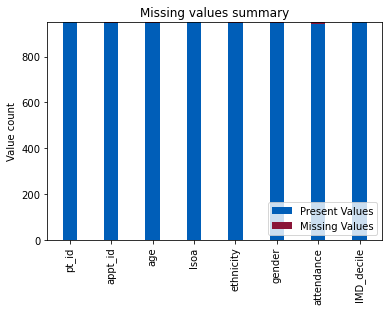

In [12]:
#consider adding second axis plot for % missing
#This could improve interpretation (where missing count small, its invisible on the chart...)

width = 0.35

fig, ax = plt.subplots()

ax.bar(data_fields, present_values, width, label="Present Values", color=nhs_blue)
ax.bar(data_fields, missing_values, width, bottom=present_values, label="Missing Values", color=nhs_dark_red)

ax.set_ylabel("Value count")
ax.set_title("Missing values summary")
ax.tick_params(axis='x', labelrotation = 90)
ax.legend(loc="lower right")

plt.show()

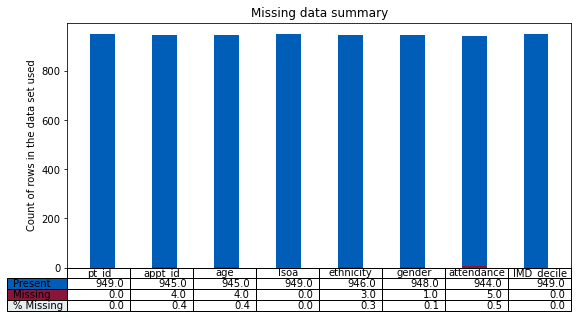

In [13]:
#https://www.pythonpool.com/matplotlib-table/
#data_quality_summary_df.loc[data_quality_summary_df['column_name'] == some_value]
plt.rcParams['figure.figsize'] = [10, 5]
data = [present, missing, missing_pct]
 
columns = data_fields
rows = list_names #present, missing, % missing 
 
colors = [nhs_blue, nhs_dark_red, nhs_pale_grey]

n_rows = len(data) #3

index = np.arange(len(columns)) + 0.3
bar_width = 0.4
 
# Initialize the vertical-offset for the stacked bar chart.
y_offset = np.zeros(len(columns))
 
# Plot bars and create text labels for the table
cell_text = []

for row in range(n_rows):
    #y_offset_edit = y_offset + data[row]
    cell_text.append([f'{x:.1f}' for x in data[row]])
    if "%" in rows[row]:
        continue
    plt.bar(index, data[row], bar_width, bottom=y_offset, color=colors[row])
 
# Add a table at the bottom of the axes
the_table = plt.table(cellText=cell_text,
                      rowLabels=rows,
                      rowColours=colors,
                      colLabels=columns,
                      loc='bottom')

the_table.auto_set_font_size(False)
the_table.set_fontsize(10)

# Adjust layout to make room for the table:
plt.subplots_adjust(left=0.2, bottom=0.2)
 
plt.ylabel("Count of rows in the data set used")

#plt.yticks(values * value_increment, ['%d' % val for val in values])
plt.xticks([])
plt.title('Missing data summary')
 
plt.show()

<h4>Checking whether missing values are missing at random, or not<h4>

<AxesSubplot:>

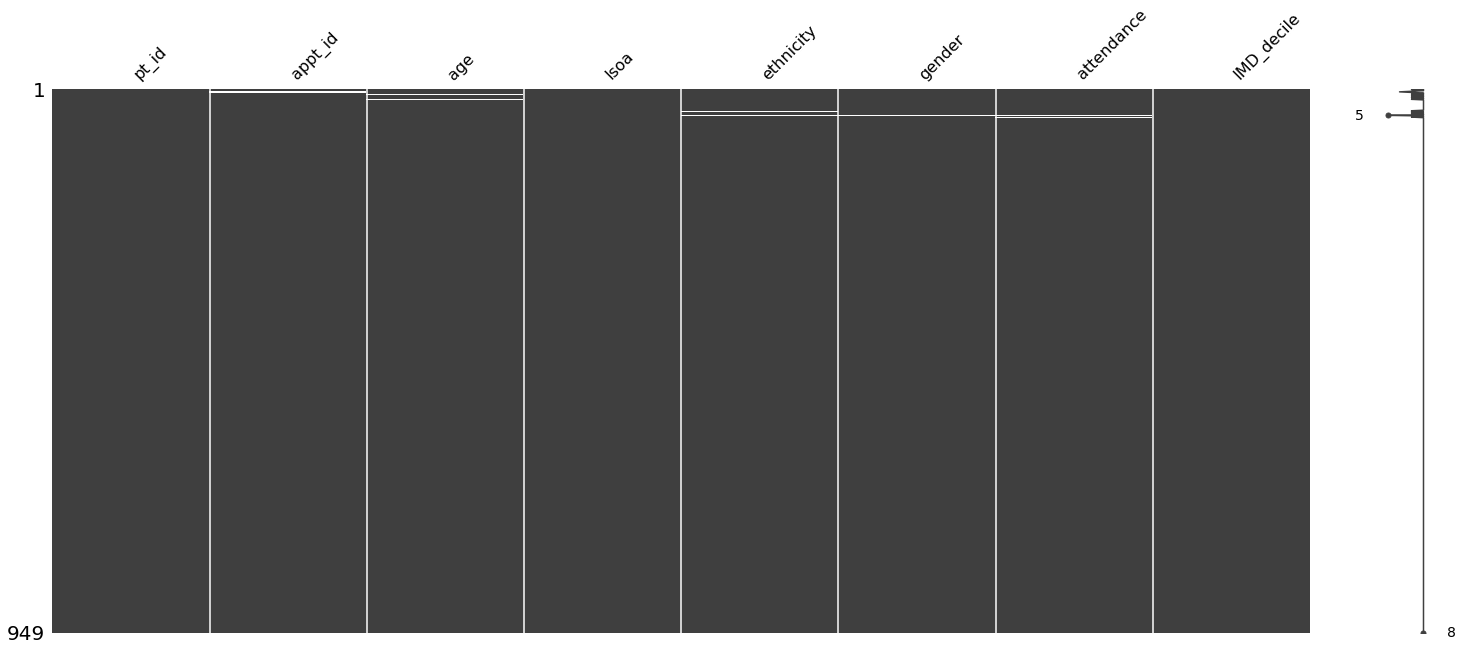

In [14]:
#Produce visualisation of missing data.
#Missing data appears as white space in the chart
#Development idea: set fig size for the this (?and possibly, all) chart(s) to ensure consistency. Esp. if creating a report at the end?
msno.matrix(df_with_imd_unique_pts)

<AxesSubplot:>

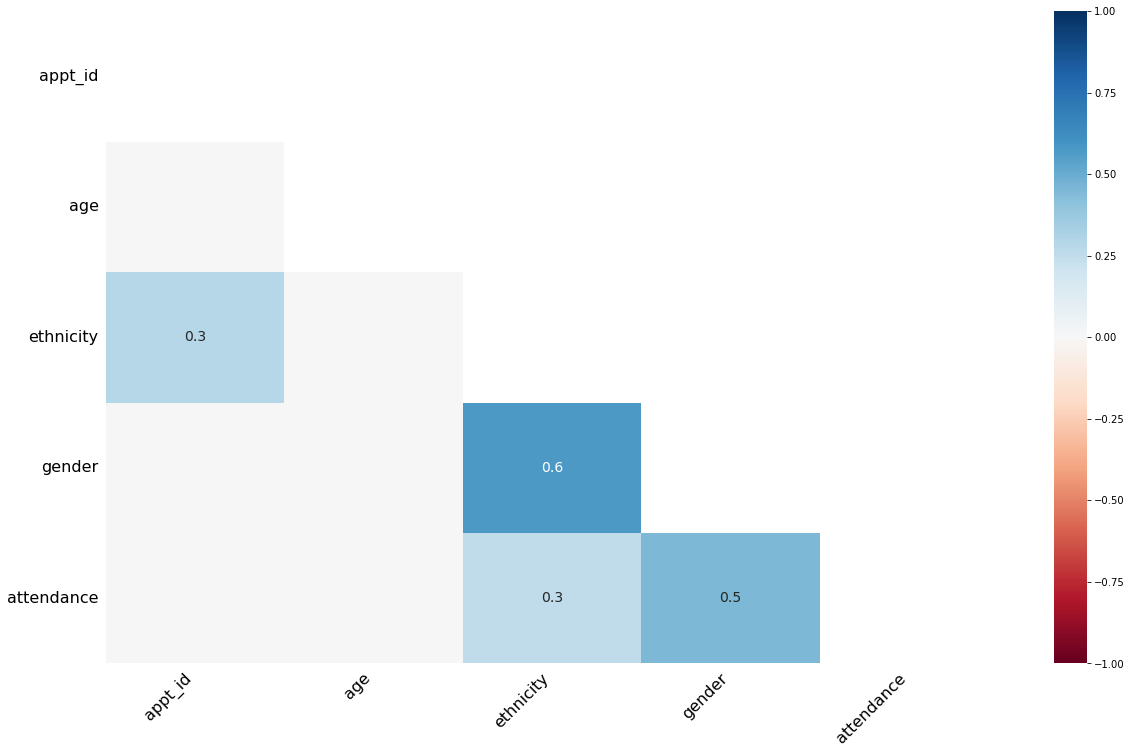

In [15]:
#The missingno correlation heatmap measures nullity correlation: 
#how strongly the presence or absence of one variable affects the presence of another: 
#(source: https://github.com/ResidentMario/missingno)

print("WARNING: Results in the below chart that show '<1' or '>-1' suggest the presence of a correlation that is close to being exactingly negative or positive (but is still not quite perfectly so) and cases requiring special attention.")

msno.heatmap(df_with_imd_unique_pts)
#df_with_imd_unique_pts.head()
#collisions = pd.read_csv("https://raw.githubusercontent.com/ResidentMario/missingno-data/master/nyc_collision_factors.csv")
#msno.heatmap(collisions)

<h1>Objective 1 Begins...<h1>

Pseudo-code plan for pre-processing stage:
1. Load modules (done)
2. Load data (done)
3. Summary of data (done)
4. Encoding non-numerical fields (convert to 0s and 1s?) (lsoa, ethnicity, gender, attendance)

Identify which fields are numeric
use those fields within a linear regression test as follows:
5a - identify rule of thumb for whether to worry / apply "handling missing values" code
5b - if handling needed, then identify whether values are missing at random or not
5c - if missing at random, impute using X process, if not impute using Y process

Identify which fields are string fields
convert those fields to int and change string values to incremental integers (1,2,3 etc.)
use these converted int fields within a logistic regression test as follows:
5d - identify rule of thumb for whether to worry / apply "handling missing values" code
5e - if handling needed, then identify whether values are missing at random or not
5f - if missing at random, impute using X process, if not impute using Y process

6. Filling in (imputing) missing data using the approach required based on the output of the above conditional logic
7. Drop columns
8. save processed data

In [16]:
"""
dict datafields (keys) and missing series (values)
iterate over values in datafields dict, check if >0
if so, create new dict of the subset where there are missing values (misisng == >0)
then, iterate over that, and use each key/value pair, plug into impute function
"""

keys = data_fields
values = missing
#dict_fieldname_missing_values = dict(zip(keys, values))
#dict_fieldname_missing_values

#Create dictionary of field names (keys) and county of missing values (values)
iterator_fieldname_missing_values = zip(keys, values)
dict_fieldname_missing_values = dict(iterator_fieldname_missing_values)

#Use this dictionary to create a list, consisting of the subset of field names, where there are missing values
#This will be used later in the program to identify which fields require missing values to be accounted for in some way
missing_values_fields = []
fields_none_missing = []

for field in data_fields:
    if dict_fieldname_missing_values[field] >0:
        missing_values_fields.append(field)
    else:
        fields_none_missing.append(field)
        
print(missing_values_fields) #Test print statement - can be deleted once complete

['appt_id', 'age', 'ethnicity', 'gender', 'attendance']


In [18]:
#Function adjusted from the titanic example by Mike Allen
def impute_missing_with_median(series):
    """
    Replace missing values in a Pandas series with median,
    Returns a comppleted series, and a series shwoing which values are imputed
    """
    
    median = series.median(skipna = True) #ignore missing values in calculation
    missing = series.isna()
    
    # Copy the series to avoid change to the original series.
    series_copy = series.copy()
    series_copy[missing] = median
    
    return series_copy, missing


#Taken from titanic - 01. pre-processing example:
def impute_missing_with_median_series(_series):
    """
    Replace missing values in a Pandas series with median,
    Returns a completed series, and a series showing which values are imputed
    """
    # Copy the series to avoid change to the original series.
    series = _series.copy()
    median = series.median()
    missing = series.isna()
    series[missing] = median
    
    return series

#Taken from titanic - 01. pre-processing example:
def impute_missing_with_median_missing(_series):
    """
    Replace missing values in a Pandas series with median,
    Returns a completed series, and a series showing which values are imputed
    """
    # Copy the series to avoid change to the original series.
    series = _series.copy()
    median = series.median()
    missing = series.isna()
    series[missing] = median
    
    return missing


In [22]:
"""
Identify which fields both have missing values and are an appropriate data type to have their median calculated.
This doesn't consider whether an int/float field is contextually appropriate to have a median calculated.
E.g. if appt_id is an incremental numeric field, it will be logically identified and assigned to int_float_fields
but, it is contextually meaningless to give a median appt_id. 
Therefore, the output of this step needs some form of user validation / approval to proceed.
This is to be handled in the next cell.
"""
#df_with_imd_unique_pts.dtypes
data_type_dict = dict(df_with_imd_unique_pts.dtypes)

int_float_fields = []
str_fields = []

#identify which fields both have missing values and are int or float type. Append to list.
for field in data_fields:
    try:
        if dict_fieldname_missing_values[field] > 0:
            median_value = df_with_imd_unique_pts[field].median() #force the except for inelligible data types / only allow floats/ints to pass to next line
            int_float_fields.append(field)
            
    except: #Add in specific error that would be expected if median cannot be calculated (not generic "all errors")
        str_fields.append(field)
        continue

print(int_float_fields) #Test print statement - can be deleted once complete. 
print(str_fields) #Test print statement - can be deleted once complete.

#print(df_with_imd_unique_pts['age'].dtype) #USE THIS TO MORE EXPLICITLY CREATE inf_float_fields and str_fields USING LIST COMPREHENSION

['appt_id', 'age']
['ethnicity', 'gender', 'attendance']
float64


In [23]:
"""
User confirmation these are all logically / contextually relevant 
(e.g. numeric patient ID could have median calculated but this doesnt make sense and
should be removed before the process to control for missing values takes place)

This function requires two input parameters: 
1. a field_list, and 
2. a data type as a string ("int" or "string")
"""

#List to populate with the fields the user decides to remove from / exclude from median (or other) missing values imputing
int_float_fields_keep = [] #fields to impute missing values for
int_float_fields_drop = [] #fields to exclude from imputing process - so either drop rows with any Nulls in these fields or exclude in ML algorithm
str_fields_keep = [] #fields to impute missing values for
str_fields_drop = [] #fields to exclude from imputing process - so either drop rows with any Nulls in these fields or exclude in ML algorithm
    
def identify_fields_to_impute(fields_list, data_type):
    #tell python which variables from the global scope to update
    global int_float_fields_keep
    global int_float_fields_drop
    global str_fields_keep
    global str_fields_drop
    
    #Create a dictionary of incremental numbers starting from 1 (keys) and 
    #field names identified in the last step as being int/float data type and having missing values (values)   
    dict_of_missing_fields = {}
    key_counter = 1
    for value in fields_list:
        dict_of_missing_fields[key_counter] = value
        key_counter += 1

    #Print to screen a numbered 'list' to the user, listing the fields that have been identified as int/float and missing values
    if data_type == "int":
        data_type_descriptor = "numeric (integer/decimal)"
    else:
        data_type_descriptor = "string (text)"
        
    print(f"The data fields with missing data that look to be {data_type_descriptor} are listed below")
    for key_number in dict_of_missing_fields:
        print(str(key_number) + " : " + str(dict_of_missing_fields[key_number]))

    #Get user confirmation that it is contextually appropriate to proceed with these fields for missing value control
    print("\nDo you want to impute missing data for all of these fields?")
    print("Please enter 'y' to continue with all fields in scope, or 'n' to choose which fields to drop")

    while True:
        try:
            selection = input("Please make a selection (y or n): ").lower()
            if selection == "y" or selection == "n":
                break
            print("Invalid selection")
        except ValueError:
            print("\nThat is not a valid selection. Please try again (y or n).")   

    #loop to choose which fields to drop from the missing value process
    if selection == "n":
        while True:
            print("\nThe data fields currently in scope are listed below:")
            for key_number in dict_of_missing_fields:
                print(f"{key_number} : {dict_of_missing_fields[key_number]}")
            print(f"0 : To continue with the current selection")
        
            while True:
                try:
                    drop_selection = int(input("\nPlease enter the number of the field to remove, or 0 to continue with the current selection:"))
                    if drop_selection in range(key_counter):
                        break
                    else:
                        print("\nThat is not a correct selection.")
                except ValueError:
                    print("Value Error - try again.")

            if drop_selection == 0:
                break
            else:
                if data_type == "int":
                    int_float_fields_drop.append(dict_of_missing_fields[drop_selection]) #create new list of fields user wants to control for missing values
                    del dict_of_missing_fields[drop_selection]
                else:
                    str_fields_drop.append(dict_of_missing_fields[drop_selection]) #create new list of fields user wants to control for missing values
                    del dict_of_missing_fields[drop_selection]

        else:
            print("Please enter a valid selection.")
    
    if data_type == "int":
        int_float_fields_keep = fields_list
        for item in int_float_fields_drop:
            int_float_fields_keep.remove(item)
    else:
        str_fields_keep = fields_list
        for item in str_fields_drop:
            str_fields_keep.remove(item)

    print()
    print(f"Great. The following {data_type_descriptor} fields will be used when controlling for missing data:")
    
    if data_type == "int": 
        for item in int_float_fields_keep:
            print(item)
    else:
        for item in str_fields_keep:
            print(item)        

            
#Dev note:
#Need to decide whether to remove df rows based on missing values in int_float_fields_drop and str_fields_drop lists or
#exclude the df columns these fields relate to entirely, 
#as ML can't handle Nulls - DECISION NEEDED -> ME/SW think remove column :)

<h4>Call function for user to confirm integer fields to retain - where there are integer fields with missing values only<h4>

In [24]:
if len(int_float_fields) > 0:
    identify_fields_to_impute(int_float_fields, "int")

The data fields with missing data that look to be numeric (integer/decimal) are listed below
1 : appt_id
2 : age

Do you want to impute missing data for all of these fields?
Please enter 'y' to continue with all fields in scope, or 'n' to choose which fields to drop
Please make a selection (y or n): n

The data fields currently in scope are listed below:
1 : appt_id
2 : age
0 : To continue with the current selection

Please enter the number of the field to remove, or 0 to continue with the current selection:1

The data fields currently in scope are listed below:
2 : age
0 : To continue with the current selection

Please enter the number of the field to remove, or 0 to continue with the current selection:0

Great. The following numeric (integer/decimal) fields will be used when controlling for missing data:
age


<h4>Call function for user to confirm string fields to retain - where there are string fields with missing values only<h4>

In [25]:
if len(str_fields) > 0:
    identify_fields_to_impute(str_fields, "string")

The data fields with missing data that look to be string (text) are listed below
1 : ethnicity
2 : gender
3 : attendance

Do you want to impute missing data for all of these fields?
Please enter 'y' to continue with all fields in scope, or 'n' to choose which fields to drop
Please make a selection (y or n): y

Great. The following string (text) fields will be used when controlling for missing data:
ethnicity
gender
attendance


In [23]:
#print statements to inform logic - delete once working
print(data_type_dict.keys())
print(data_type_dict.values())
print(dict_fieldname_missing_values.values())
print(data_fields)

dict_keys(['pt_id', 'appt_id', 'age', 'lsoa', 'ethnicity', 'gender', 'attendance', 'IMD_decile'])
dict_values([dtype('int64'), dtype('float64'), dtype('float64'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('int64')])
dict_values([0.0, 4.0, 4.0, 0.0, 3.0, 1.0, 5.0, 0.0])
['pt_id', 'appt_id', 'age', 'lsoa', 'ethnicity', 'gender', 'attendance', 'IMD_decile']


<h4>Create function to impute label fields<h4> 

In [31]:
#Consider how to change the terminology used here, in case the term "missing" is used in the actual data set passed
#Taken from titanic - 01. pre-processing example:
def impute_missing_with_missing_label(series):
    """Replace missing values in a Pandas series with the text 'missing'"""

    missing = series.isna()    
    
    # Copy the series to avoid change to the original series.
    series_copy = series.copy()
    series_copy[missing] = 'missing'
    
    return series_copy, missing

In [32]:
dict_ints_imputed = {}
dict_ints_imputed_missing = {}
dict_str_imputed = {}
dict_str_imputed_missing = {}

In [33]:
def impute_missing(field_list, data_type):
    
    #Tell the function to update variables that exist in the global space, and not locally within the function
    global dict_ints_imputed
    global dict_ints_imputed_missing
    global dict_str_imputed
    global dict_str_imputed_missing
    
    if data_type == "int":
        for field in field_list:
            series, missing = impute_missing_with_median(df_with_imd_unique_pts[field])
            dict_ints_imputed[field] = series
            dict_ints_imputed_missing[field] = missing

    else:
        for field in field_list:
            series, missing = impute_missing_with_missing_label(df_with_imd_unique_pts[field])
            dict_str_imputed[field] = series
            dict_str_imputed_missing[field] = missing

<h4>Call the function to impute missing int/float fields using the median<h4>

In [34]:
impute_missing(int_float_fields_keep, "int")

<h4>Call the function to impute missing string fields with the word "missing"<h4>

In [35]:
impute_missing(str_fields_keep, "string")

In [36]:
final_processed_df = pd.DataFrame()

data_fields_copy = data_fields.copy()

for field in data_fields:
    if field in int_float_fields_drop:
        data_fields_copy.remove(field)
    elif field in int_float_fields_keep:
        data_fields_copy.remove(field)
    elif field in str_fields_drop:
        data_fields_copy.remove(field)
    elif field in str_fields_keep:
        data_fields_copy.remove(field)

for field in data_fields_copy:
    final_processed_df[field] = df_with_imd_unique_pts[field]

In [37]:
if len(int_float_fields_keep) > 0:
    for field in int_float_fields_keep:
        #final_processed_df[field] = (df_with_imd_unique_pts[field]) #Exclue original field with nulls
        final_processed_df[field+'_with_median'] = dict_ints_imputed[field]
        final_processed_df[field+'_Null_replaced'] = dict_ints_imputed_missing[field]

if len(str_fields_keep) > 0:
    for field in str_fields_keep:
        #final_processed_df[field] = (df_with_imd_unique_pts[field]) #Exclue original field with nulls
        final_processed_df[field+'_with_missing'] = dict_str_imputed[field]
        final_processed_df[field+'_Null_replaced'] = dict_str_imputed_missing[field]

In [33]:
#The final processed df:
#1. includes fields that originally had no missing data
#2. excludes fields that had missing data, but the user decided to drop / not impute
#3. includes fields that originally had missing data, and the user imputed data for missing values

#final_processed_df.info()


pt_id                       0
lsoa                        0
IMD_decile                  0
age_with_median             0
age_Null_replaced           0
ethnicity_with_missing      0
ethnicity_Null_replaced     0
gender_with_missing         0
gender_Null_replaced        0
attendance_with_missing     0
attendance_Null_replaced    0
dtype: int64

<h1>Dev Note: Check if median is appropriate for all numeric fields or how to decide which approach to use, if we dont always use the median<h1>

In [30]:
#Titanic section for cabin data has been removed (handling one passenger with many rooms)

In [38]:
final_processed_df.head()

,pt_id,lsoa,IMD_decile,age_with_median,age_Null_replaced,ethnicity_with_missing,ethnicity_Null_replaced,gender_with_missing,gender_Null_replaced,attendance_with_missing,attendance_Null_replaced
0,1,E01019686,10,18.0,False,Black,False,Male,False,Patient cancelled,False
1,2,E01013501,4,60.0,False,Black,False,Male,False,DNA,False
3,3,E01019414,8,31.0,False,Asian,False,Non-binary,False,Service cancelled,False
8,4,E01019596,8,39.0,False,Mixed,False,Other,False,DNA,False
12,5,E01019412,10,23.0,False,Other,False,Transgender,False,DNA,False


In [41]:
#identify the fields that are labels and not numbers (as the encoding will be done on label data only)
final_processed_data_fields = list(final_processed_df.columns)
fields_to_drop = []
fields_to_encode = []

for field in final_processed_data_fields:
    if field != patient_id:
        try:
            median_value = int(final_processed_df[field].median()) #force the except for inelligible data types / only allow string to pass to next line
            fields_to_drop.append(field)
        except:
            fields_to_encode.append(field)
            continue

#create function to encode all relevant fields for a given data frame and list of fields to encode, passed into the function as parameters
def encoding_dataframe(dataframe, field_list):
    
    #Create blank dataframe that will be populated with encoded series
    encoded_dataframe = pd.DataFrame()
    
    #iterate through all fields in the dataframe passed to the function
    for field in field_list:       
        
        #encode the current field in the loop and create a dataframe for the current fields encoding 
        field_encoded = pd.get_dummies(dataframe[field], prefix="encoded_")
        
        #concatenate the current fields encoding with the newly create dataframe above
        encoded_dataframe = pd.concat([encoded_dataframe, field_encoded], axis=1)
        
    return encoded_dataframe

#call the function
encoded_dataframe = encoding_dataframe(final_processed_df, fields_to_encode)

print(encoded_dataframe.head())

    encoded__E01013453  encoded__E01013454  encoded__E01013455  \
0                    0                   0                   0   
1                    0                   0                   0   
3                    0                   0                   0   
8                    0                   0                   0   
12                   0                   0                   0   

    encoded__E01013456  encoded__E01013457  encoded__E01013458  \
0                    0                   0                   0   
1                    0                   0                   0   
3                    0                   0                   0   
8                    0                   0                   0   
12                   0                   0                   0   

    encoded__E01013459  encoded__E01013460  encoded__E01013461  \
0                    0                   0                   0   
1                    0                   0                   0   
3       

<h1>All done! Save pre-processed data<h1> 

In [80]:
os.makedirs('processed_data', exist_ok=True)  
encoded_dataframe.to_csv('processed_data/processed_data.csv')  

#encoded_dataframe.to_csv('./data/processed_data.csv', index=False)